# Example of a Poisoning Attacks on the MNIST dataset


In this tutorial we show how to load the **MNIST handwritten digits dataset** 
 and use it to train a Support Vector Machine (SVM).

Later we are going to perform a Poisoning Attack against the trained
 classifier.


In a data poisoning attack, the attacker identifies the source of raw data used to train the model, then strives to bias or “poison” the data to compromise the resulting machine learning model’s accuracy. 

The attacker needs access to raw data, meaning the hacker needs to be on the inside or use other methods to target employees to gain access. 

## Install the libraries

In [1]:
%%capture --no-stderr --no-display
# NBVAL_IGNORE_OUTPUT

try:
  import secml
except ImportError:
  %pip install git+https://github.com/pralab/secml

## Training of the classifier

First, we load the dataset and train the classifier. For this tutorial, 
 we only consider 2 digits, the 5 (five) and the 9 (nine).

In [2]:
# NBVAL_IGNORE_OUTPUT
from secml.data.loader import CDataLoaderMNIST

# MNIST dataset will be downloaded and cached if needed
loader = CDataLoaderMNIST()

2022-11-09 15:01:59,498 - secml.settings - INFO - New `SECML_HOME_DIR` created: /root/secml-data
2022-11-09 15:01:59,498 - secml.settings - INFO - New `SECML_HOME_DIR` created: /root/secml-data


INFO:secml.settings:New `SECML_HOME_DIR` created: /root/secml-data


2022-11-09 15:01:59,506 - secml.settings - INFO - Default configuration file copied to: /root/secml-data/secml.conf
2022-11-09 15:01:59,506 - secml.settings - INFO - Default configuration file copied to: /root/secml-data/secml.conf


INFO:secml.settings:Default configuration file copied to: /root/secml-data/secml.conf


2022-11-09 15:01:59,510 - secml.settings - INFO - New `SECML_DS_DIR` created: /root/secml-data/datasets
2022-11-09 15:01:59,510 - secml.settings - INFO - New `SECML_DS_DIR` created: /root/secml-data/datasets


INFO:secml.settings:New `SECML_DS_DIR` created: /root/secml-data/datasets


2022-11-09 15:01:59,513 - secml.settings - INFO - New `SECML_MODELS_DIR` created: /root/secml-data/models
2022-11-09 15:01:59,513 - secml.settings - INFO - New `SECML_MODELS_DIR` created: /root/secml-data/models


INFO:secml.settings:New `SECML_MODELS_DIR` created: /root/secml-data/models


2022-11-09 15:01:59,517 - secml.settings - INFO - New `SECML_EXP_DIR` created: /root/secml-data/experiments
2022-11-09 15:01:59,517 - secml.settings - INFO - New `SECML_EXP_DIR` created: /root/secml-data/experiments


INFO:secml.settings:New `SECML_EXP_DIR` created: /root/secml-data/experiments


2022-11-09 15:01:59,520 - secml.settings - INFO - New `SECML_LOGS_DIR` created: /root/secml-data/logs
2022-11-09 15:01:59,520 - secml.settings - INFO - New `SECML_LOGS_DIR` created: /root/secml-data/logs


INFO:secml.settings:New `SECML_LOGS_DIR` created: /root/secml-data/logs


2022-11-09 15:01:59,524 - secml.settings - INFO - New `SECML_PYTORCH_DIR` created: /root/secml-data/pytorch-data
2022-11-09 15:01:59,524 - secml.settings - INFO - New `SECML_PYTORCH_DIR` created: /root/secml-data/pytorch-data


INFO:secml.settings:New `SECML_PYTORCH_DIR` created: /root/secml-data/pytorch-data



File stored in `/root/secml-data/datasets/mnist/train-images-idx3-ubyte.gz`

File stored in `/root/secml-data/datasets/mnist/train-labels-idx1-ubyte.gz`

File stored in `/root/secml-data/datasets/mnist/t10k-images-idx3-ubyte.gz`

File stored in `/root/secml-data/datasets/mnist/t10k-labels-idx1-ubyte.gz`


In [3]:
random_state = 999

n_tr = 100  # Number of training set samples
n_val = 500  # Number of validation set samples
n_ts = 500  # Number of test set samples

digits = (5, 9)

tr_val = loader.load('training', digits=digits, num_samples=n_tr + n_val)
ts = loader.load('testing', digits=digits, num_samples=n_ts)

# Split in training and validation set
tr = tr_val[:n_tr, :]
val = tr_val[n_tr:, :]

# Normalize the features in `[0, 1]`
tr.X /= 255
val.X /= 255
ts.X /= 255

from secml.ml.classifiers import CClassifierSVM
# train SVM in the dual space, on a linear kernel, as needed for poisoning
clf = CClassifierSVM(C=10, kernel='linear')

print("Training of classifier...")
clf.fit(tr.X, tr.Y)

# Compute predictions on a test set
y_pred = clf.predict(ts.X)

# Metric to use for performance evaluation
from secml.ml.peval.metrics import CMetricAccuracy
metric = CMetricAccuracy()

# Evaluate the accuracy of the classifier
acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)

print("Accuracy on test set: {:.2%}".format(acc))

Training of classifier...
Accuracy on test set: 93.60%


In [4]:
from secml.figure import CFigure
# Only required for visualization in notebooks
%matplotlib inline

# Let's define a convenience function to easily plot the MNIST dataset
def show_digits(samples, preds, labels, digs, n_display=8):
    samples = samples.atleast_2d()
    n_display = min(n_display, samples.shape[0])
    fig = CFigure(width=n_display*2, height=3)
    for idx in range(n_display):
        fig.subplot(2, n_display, idx+1)
        fig.sp.xticks([])
        fig.sp.yticks([])
        fig.sp.imshow(samples[idx, :].reshape((28, 28)), cmap='gray')
        fig.sp.title("{} ({})".format(digits[labels[idx].item()], digs[preds[idx].item()]),
                     color=("green" if labels[idx].item()==preds[idx].item() else "red"))
    fig.show()


## Poisoning attack with MNIST dataset

We set the the bounds of the attack space and the number of adversarial points to generate, 50 in this example. 
Lastly, we chose the solver parameters for this specific optimization problem.

*Please note that the attack using the MNIST dataset may take a while 
 (up to a few minutes) depending on the machine the script is run on.*
 

Attack started...
Attack complete!
Original accuracy on test set: 93.60%
Accuracy after attack on test set: 50.40%


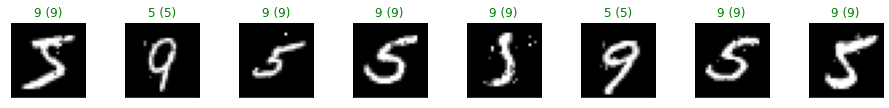

In [5]:
lb, ub = 0., 1.  # Bounds of the attack space. Can be set to `None` for unbounded
n_poisoning_points = 15  # Number of poisoning points to generate

# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.25,
    'eta_min': 2.0,
    'eta_max': None,
    'max_iter': 100,
    'eps': 1e-6
}

from secml.adv.attacks import CAttackPoisoningSVM
pois_attack = CAttackPoisoningSVM(classifier=clf,
                                  training_data=tr,
                                  val=val,
                                  lb=lb, ub=ub,
                                  solver_params=solver_params,
                                  random_seed=random_state)
pois_attack.n_points = n_poisoning_points

# Run the poisoning attack
print("Attack started...")
pois_y_pred, _, pois_points_ds, _ = pois_attack.run(ts.X, ts.Y)
print("Attack complete!")

# Evaluate the accuracy of the original classifier
acc = metric.performance_score(y_true=ts.Y, y_pred=clf.predict(ts.X))
# Evaluate the accuracy after the poisoning attack
pois_acc = metric.performance_score(y_true=ts.Y, y_pred=pois_y_pred)

print("Original accuracy on test set: {:.2%}".format(acc))
print("Accuracy after attack on test set: {:.2%}".format(pois_acc))

# Training of the poisoned classifier for visualization purposes
pois_clf = clf.deepcopy()
pois_tr = tr.append(pois_points_ds)  # Join the training set with the poisoning points
pois_clf.fit(pois_tr.X, pois_tr.Y)

show_digits(pois_points_ds.X, pois_clf.predict(pois_points_ds.X), 
            pois_points_ds.Y, digits)

We can see that the classifier trained on the MNIST dataset has been 
 successfully poisoned. To increase the attack power, more poisoning points
 can be crafted, at the expense of a much slower optimization process.
 
Let's note that the label of each adversarial example we show has been 
 *flipped* by the attack with respect to the actual true label. Thus, the 
 predicted label (parenthesis) by the poisoned classifier is displayed 
 in green when *different* from the true label of the digit.